# Rubin ToO Strategies

Notebook template author: Igor Andreoni <igor.andreoni@gmail.com>

This notebook was put together to aid visualization of possible strategies to adopt for Target of Opportunity (ToO) observations with Vera C. Rubin Observatory. The template code was used to produce some figures published in Andreoni et al. (2022), The Astrophysical Journal Supplement Series, Volume 260, Issue 1, id.18, 17 pp.

### Requirements

Python3

- numpy
- matplotlib
- math
- collections

Custom scripts
- chart.py
- etc.py

### Run the cells

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd

# Import the custom exposure time calculator
import etc

# Import the function to make the Gantt chart
from chart import makeChart

Build a dictionary with the strategies that you want to be seen on the same plot. 
The keys of the dictionary will be the nicknames of the strategies (for example, `strategy1`, `strategy2`).

Notes:
- The LSSTCam filter wheel holds 5 filters on a given night. The bluer and redder filters, u and y, will be swapped depending on the lunation. If all 6 filters are added to the plot, we shall assume that 5 available filters will be used in the ToOs.
- The length of the exposure time list (`exptimes` key) must be the same length as the cadence list (`cadence_hr` key) and the filters list (`filters` key)
- The cadence must be given in hours, the exposure times in seconds, the filters as a list or in the form `'ugrizy'`
- The `depths` are 5sigma limiting magnitudes in all bands, the corresponding exptime will be the median of the exposure times for the filters provided in each strategy
- <b>Important:</b> If both "depths" and "exposures" are given, "depths" will dominate.

In [2]:
strategies = {
    'Strategy 1 blue': {"cadence_hr": [1, 4, 24, 48],
                   "exptimes": [30, 30, 60, 180],
                   "depths": [24.5, 24.5, 24.5, 24.5],
                   "filters": ['ugr', 'ugr', 'g', 'g']},
    'Strategy 1 red': {"cadence_hr": [1, 4, 24, 48],
                   "exptimes": [30, 30, 60, 180],
                   "depths": [24.5, 24.5, 24.5, 24.5],
                   "filters": ['izy', 'izy', 'z', 'z']},
    'Fabulous Strategy': {"cadence_hr": [4, 24, 48],
                   "exptimes": [],
                   "depths": [24.5, 25, 25],
                   "filters": ['ugrizy', 'ugrizy', 'ugrizy']},
    #'Strategy 3': {"cadence_hr": [1, 4, 24],
    #               "exptimes": [],
    #               "depths": [24, 24, 24],
    #               "filters": ['ugrizy', 'ugrizy', 'gz']},
}

strategies = {
    'Fabulous Strategy': {"cadence_hr": [4, 24, 48],
                   "exptimes_median": [],
                   "exptimes": [],
                   "depths": [24.5, 25, 25],
                   "filters": ['ugrizy', 'ugrizy', 'ugrizy']}
}

# When is the timeline starting? e.g., Rubin Trigger, NS-NS merger, ...
event_name = "start of Rubin observing window"

# Output file name
filename_out = "plot_strategy.pdf"

# Define the colors for the Rubin filters
filters_color_dict = {'u':'b', 'g':'g', 'r':'r', 'i':'yellow', 'z':'k', 'y':'orange'}

# Define the sequence of markers for different exposure times
# (the sequence will be ordered by increasing exposure time)
exptimes_marker_list = ["o", "s", "p", "h", "8", '^']

### Plot the Gantt chart

Using DEPTHS to calculate the exposure times
    Epoch: 24.5 hr
        Filter: u Depth: 24.5mag, exptime: 131s
        Filter: g Depth: 24.5mag, exptime: 13s
        Filter: r Depth: 24.5mag, exptime: 29s
        Filter: i Depth: 24.5mag, exptime: 60s
        Filter: z Depth: 24.5mag, exptime: 170s
        Filter: y Depth: 24.5mag, exptime: 1088s
Median exposure time: 96s
    Epoch: 25 hr
        Filter: u Depth: 25mag, exptime: 330s
        Filter: g Depth: 25mag, exptime: 32s
        Filter: r Depth: 25mag, exptime: 73s
        Filter: i Depth: 25mag, exptime: 150s
        Filter: z Depth: 25mag, exptime: 428s
        Filter: y Depth: 25mag, exptime: 2732s
Median exposure time: 240s
    Epoch: 25 hr
        Filter: u Depth: 25mag, exptime: 330s
        Filter: g Depth: 25mag, exptime: 32s
        Filter: r Depth: 25mag, exptime: 73s
        Filter: i Depth: 25mag, exptime: 150s
        Filter: z Depth: 25mag, exptime: 428s
        Filter: y Depth: 25mag, exptime: 2732s
Median exposu

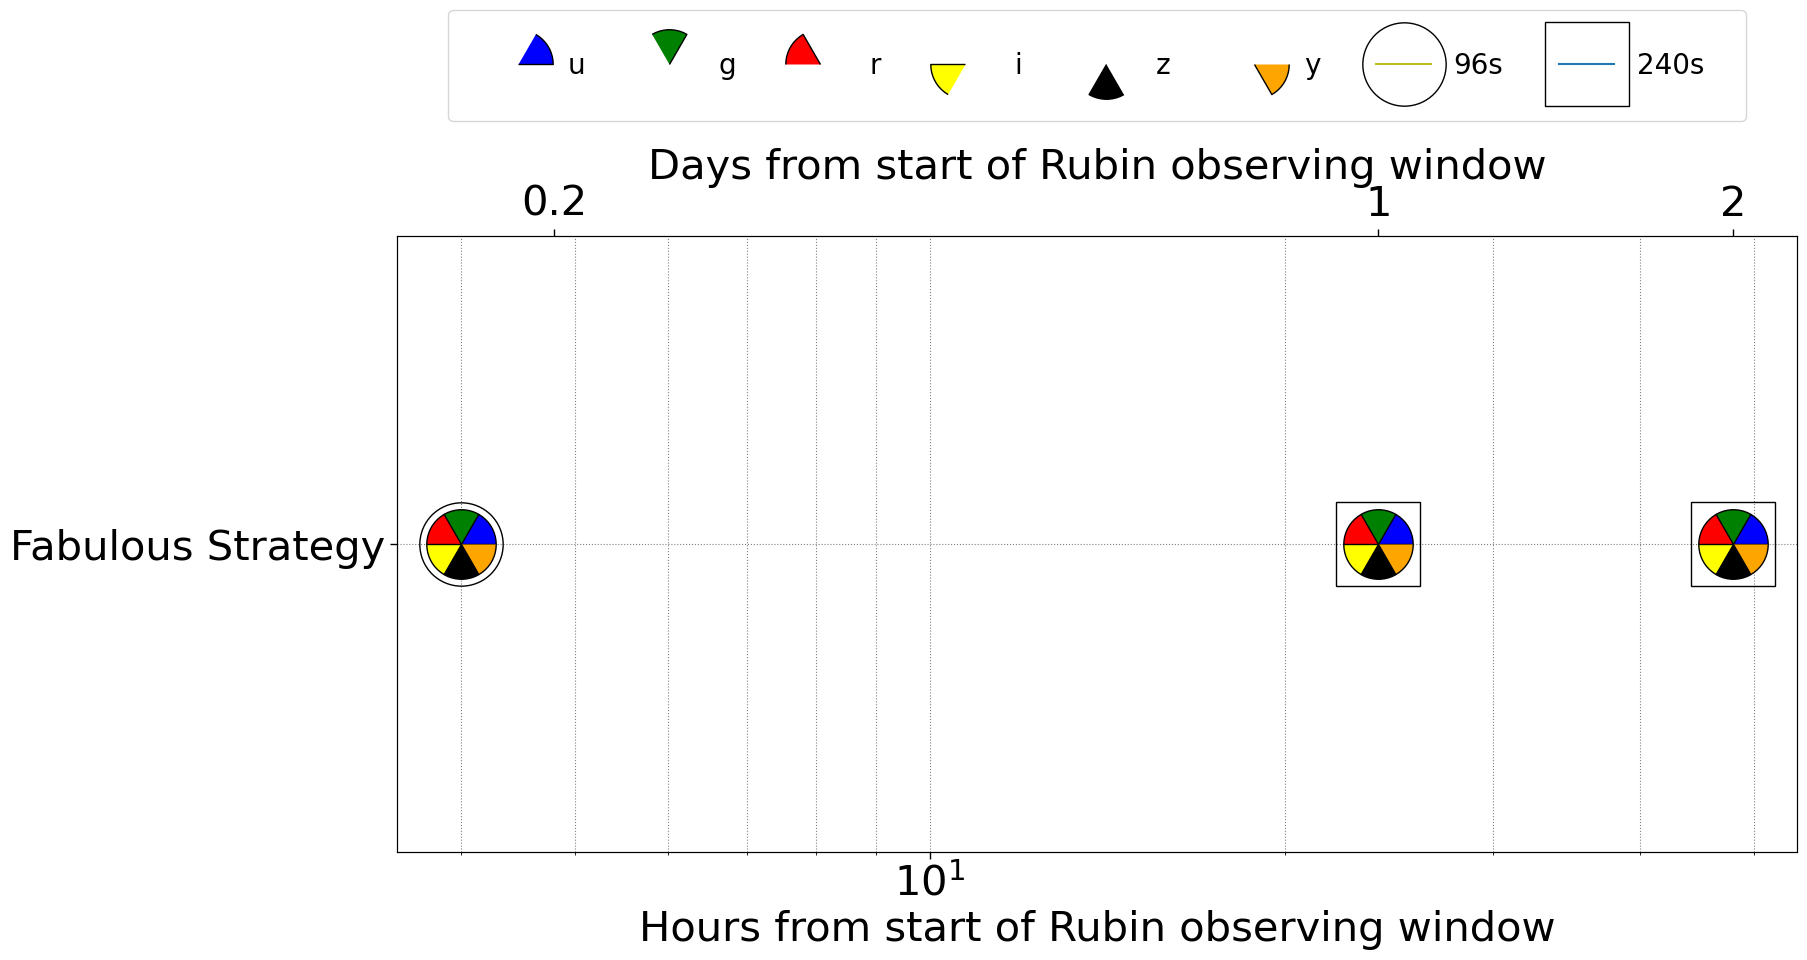

In [3]:
# If depths are given, then compute the exposure times
strategy_names = list(strategies.keys())
for i in range(len(strategy_names)):
    # Check if depths are given, as they will dominate
    if len(strategies[strategy_names[i]]["depths"]) > 0:
        print("Using DEPTHS to calculate the exposure times")
        # Initiate the exposure times list
        strategies[strategy_names[i]]["exptimes"] = []
        #Get exposure times, print results:
        for j in np.arange(len(strategies[strategy_names[i]]["depths"])):
            depth = strategies[strategy_names[i]]["depths"][j]
            # Iterate over the filters
            exptimes_epoch = [] # Get the average exposure time for a given epoch 
            print(f"    Epoch: {strategies[strategy_names[i]]['depths'][j]} hr")
            for filt in strategies[strategy_names[i]]["filters"][j]:
                exptime = int(np.round(etc.get_exptime(depth, filt)))
                print(f"        Filter: {filt} Depth: {depth}mag, exptime: {exptime}s")
                exptimes_epoch.append(exptime)
            # Add the average exposure time to the strategies dictionary
            strategies[strategy_names[i]]["exptimes_median"].append(int(np.round(np.median(exptimes_epoch))))
            print(f"Median exposure time: {int(np.round(np.median(exptimes_epoch)))}s")
            # Detailed exposure times
            strategies[strategy_names[i]]["exptimes"].append([int(np.round(x)) for x in exptimes_epoch])
          
    else:
        print("Using EXPOSURE TIMES to calculate the depths")
        # TO BE CODED .....

# Create the gantt chart
fig, ax = makeChart(strategies, event=event_name,
                    filters_color_dict=filters_color_dict,
                    exptimes_marker_list=exptimes_marker_list)

# Save the figure and show the plot
plt.savefig(filename_out, bbox_inches='tight')
plt.show()

See how the `strategies` dictionary has been populated

In [4]:
strategies

{'Fabulous Strategy': {'cadence_hr': [4, 24, 48],
  'exptimes_median': [96, 240, 240],
  'exptimes': [[131, 13, 29, 60, 170, 1088],
   [330, 32, 73, 150, 428, 2732],
   [330, 32, 73, 150, 428, 2732]],
  'depths': [24.5, 25, 25],
  'filters': ['ugrizy', 'ugrizy', 'ugrizy']}}

Print the results in a more readable format

In [5]:
for i in range(len(strategy_names)):
    print(f"\n Strategy name: {strategy_names[i]}")
    # Iterate over the epochs
    for j in np.arange(len(strategies[strategy_names[i]]["depths"])):
            depth = strategies[strategy_names[i]]["depths"][j]
            print(f"    Epoch: {strategies[strategy_names[i]]['depths'][j]} hr")
            # Iterate over the filters
            for filt, exptime in zip(strategies[strategy_names[i]]["filters"][j], strategies[strategy_names[i]]["exptimes"][j]):
                print(f"        Filter: {filt} Depth: {depth}mag, exptime: {exptime}s")
            print(f"        Median exposure time: {int(np.round(np.median(exptimes_epoch)))}s")
    print("--")
    


 Strategy name: Fabulous Strategy
    Epoch: 24.5 hr
        Filter: u Depth: 24.5mag, exptime: 131s
        Filter: g Depth: 24.5mag, exptime: 13s
        Filter: r Depth: 24.5mag, exptime: 29s
        Filter: i Depth: 24.5mag, exptime: 60s
        Filter: z Depth: 24.5mag, exptime: 170s
        Filter: y Depth: 24.5mag, exptime: 1088s
        Median exposure time: 240s
    Epoch: 25 hr
        Filter: u Depth: 25mag, exptime: 330s
        Filter: g Depth: 25mag, exptime: 32s
        Filter: r Depth: 25mag, exptime: 73s
        Filter: i Depth: 25mag, exptime: 150s
        Filter: z Depth: 25mag, exptime: 428s
        Filter: y Depth: 25mag, exptime: 2732s
        Median exposure time: 240s
    Epoch: 25 hr
        Filter: u Depth: 25mag, exptime: 330s
        Filter: g Depth: 25mag, exptime: 32s
        Filter: r Depth: 25mag, exptime: 73s
        Filter: i Depth: 25mag, exptime: 150s
        Filter: z Depth: 25mag, exptime: 428s
        Filter: y Depth: 25mag, exptime: 2732s
      

### Plot transient light curve

Plot the light curve of a transient given the strategy defined above.

In [6]:
import glob

import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.ticker import MaxNLocator
from astropy.cosmology import Planck18 as cosmo
import astropy.cosmology as ac
import astropy.units as u

import plot_lc

For plotting kilonovae, choose relevant parameters

Models come in CSV or ASCII files. check out the `/models` folder and copy the format if you want to add your favorite model.

One important parameter is `delay_hr`, which is the delay time between the onset of the transient (e.g., the merger of two compact objects) and the start of the observability window. Note that `cadence_hr` starts from the beginning of the observability window, since we cannot predict when the onset is, if the event happens during the Chilean daytime.

In [7]:
delay_hr = 6.

model_filename = "models/kilonova_Bulla/nph1.0e+06_dyn0.001-0.15-0.20_wind0.050-0.03_theta25.84_z0.2.dat"


 Strategy name: Fabulous Strategy


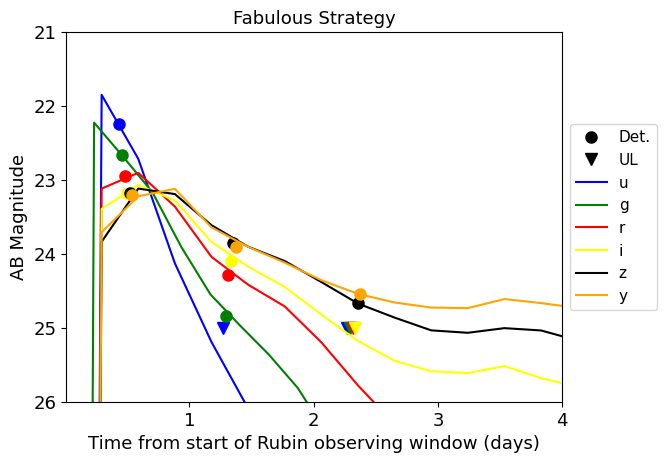

In [8]:
# Read the model
t_model = ascii.read(model_filename)
# Do plot 
plot_lc.doPlotLc(strategies, t_model,
                 delay_hr,  # delay time between merger and observing window
                 xlim=[0.01, 4], # x axis limit in apparent mag
                 ylim=[26, 21],  # y axis limit in apparent mag
                 n_interp=100,  # Number of points for the interpolation (e.g. 150)
                 offset_filt_hr=0.5,  # offset in hours between filters (to show overlapping points)
                 outfile_base="plot_lc",  # Base name for the file to be saved
                 outfile_format='pdf',  # Format of the output plot (pdf, png, etc)
                 doSave=True,  # If set to False, the plot will not be saved
                 event_name=event_name,  # Name of the event for the X label
                 linestyle="-",
                 filters_color_dict=filters_color_dict)

### Time budget

Based on the strategies adopted, compute the time budget. Some parameters need to be defined, such as overheads between exposures and rates.

Overheads are calculated by multiplying the overhead per exposure * the number of exposures, which accounts for slewing to the first field.

In [9]:
# Overheads
overhead_between_exposures = 10.  # in seconds

# Overhead first slew per epoch, assuming it may be further away than tiling
overhead_first_slew = 30

# Number of fields
n_fields = 10

# Number of events to follow-up
n_events = 5

In [10]:
for i in range(len(strategy_names)):
    exptimes = strategies[strategy_names[i]]["exptimes"]
    # Number of exposures
    n_exposures = len(np.concatenate(exptimes))
    # calculate the overheads, convert overhead from s hours
    overheads = np.sum(overhead_between_exposures/60/60 * (n_exposures-1)) + overhead_first_slew * len(exptimes)/60/60
    # calculate the total exposure time per field/pointing in hours
    total_exposure_time_hr = np.sum(np.concatenate(exptimes))/60/60
    # calculate the time budget in hours
    budget_strategy_hr = total_exposure_time_hr + overheads
    {'{:.1f}'.format(budget_strategy_hr)}
    
    print(f"\n Strategy name: {strategy_names[i]}")
    print(f"Total exposure time per pointing: {'{:.1f}'.format(total_exposure_time_hr)}hr")
    print(f"Total overheads per pointing: {'{:.2f}'.format(overheads)} ({overheads/budget_strategy_hr}% of total budget)")
    print(f"Total time budget per pointing: {'{:.1f}'.format(budget_strategy_hr)}hr")
    print(f"Total time for {n_fields} fields: {'{:.1f}'.format(budget_strategy_hr * n_fields)}hr")
    print(f"Total time for {n_fields} fields and {n_events} events: {'{:.1f}'.format(budget_strategy_hr * n_fields * n_events)}hr")
    print("-- \n")


 Strategy name: Fabulous Strategy
Total exposure time per pointing: 2.5hr
Total overheads per pointing: 0.07 (0.028135483172816788% of total budget)
Total time budget per pointing: 2.6hr
Total time for 10 fields: 25.7hr
Total time for 10 fields and 5 events: 128.3hr
-- 



### Exposure Time Calculator

From a given filter and magnitude limit (5 sigma), get the exposure time

In [11]:
# Import the custom exposure time calculator
import etc

In [12]:
# Define filters and magnitude limits
filters = "ugrizy"
mag_limits = [24.5, 24.5, 24.5, 24.5, 24.5, 24.5]  # in AB mag

In [13]:
print("filter, mag_limit, exptime (s)")
for filt, mag in zip(filters, mag_limits):
    exptime = int(np.round(etc.get_exptime(mag, filt)))
    print(f"{filt}, {mag}, {exptime}")

filter, mag_limit, exptime (s)
u, 24.5, 131
g, 24.5, 13
r, 24.5, 29
i, 24.5, 60
z, 24.5, 170
y, 24.5, 1088


Now from a given filter and exposure time, get the magnitude limit (5 sigma)

In [14]:
# Define filters and exp times
filters = "ugrizy"
exptimes = [30, 30, 60, 60, 60, 60]  # in seconds

In [15]:
print("filter, mag_limit, exptime (s)")
for filt, exptime in zip(filters, exptimes):
    mag = etc.get_m5(exptime, filt)
    print(f"{filt}, {'{:.1f}'.format(mag)}, {exptime}")

filter, mag_limit, exptime (s)
u, 23.7, 30
g, 25.0, 30
r, 24.9, 60
i, 24.5, 60
z, 23.9, 60
y, 22.9, 60
